# Regression
## Predicting Boston Housing Prices

In [4]:
#import libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd; pd.options.display.float_format = '{:,.3f}'.format
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [5]:
#column names
col_name = ['CRIM', 'ZN' , 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

#load data
df = pd.read_csv('data/housing.data', delim_whitespace = True, header =None, names =col_name)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.006,18.000,2.310,0,0.538,6.575,65.200,4.090,1,296.000,15.300,396.900,4.980,24.000
1,0.027,0.000,7.070,0,0.469,6.421,78.900,4.967,2,242.000,17.800,396.900,9.140,21.600
2,0.027,0.000,7.070,0,0.469,7.185,61.100,4.967,2,242.000,17.800,392.830,4.030,34.700
3,0.032,0.000,2.180,0,0.458,6.998,45.800,6.062,3,222.000,18.700,394.630,2.940,33.400
4,0.069,0.000,2.180,0,0.458,7.147,54.200,6.062,3,222.000,18.700,396.900,5.330,36.200


### Data Definitions

- **AGE**: proportion of owner-occupied units built prior to 1940
- **B**: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- **CHAS**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- **CRIM**: per capita crime rate by town
- **DIS**: weighted distances to five Boston employment centres
- **INDUS**: proportion of non-retail business acres per town
- **LSTAT**: % lower status of the population
- **MEDV**: Median value of owner-occupied homes in \$1000's
- **NOX**: nitric oxides concentration (parts per 10 million)
- **PTRATIO**: pupil-teacher ratio by town
- **RAD**: index of accessibility to radial highways
- **RM**: average number of rooms per dwelling
- **TAX**: full-value property-tax rate per $10,000
- **ZN**: proportion of residential land zoned for lots over 25,000 sq.ft.

### Exploratory Data Analysis

In [6]:
# describe the dataset
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000
mean,3.614,11.364,11.137,0.069,0.555,6.285,68.575,3.795,9.549,408.237,18.456,356.674,12.653,22.533
std,8.602,23.322,6.860,0.254,0.116,0.703,28.149,2.106,8.707,168.537,2.165,91.295,7.141,9.197
min,0.006,0.000,0.460,0.000,0.385,3.561,2.900,1.130,1.000,187.000,12.600,0.320,1.730,5.000
25%,0.082,0.000,5.190,0.000,0.449,5.886,45.025,2.100,4.000,279.000,17.400,375.377,6.950,17.025
50%,0.257,0.000,9.690,0.000,0.538,6.208,77.500,3.207,5.000,330.000,19.050,391.440,11.360,21.200
75%,3.677,12.500,18.100,0.000,0.624,6.623,94.075,5.188,24.000,666.000,20.200,396.225,16.955,25.000
max,88.976,100.000,27.740,1.000,0.871,8.780,100.000,12.127,24.000,711.000,22.000,396.900,37.970,50.000


> Comparing the mean and median will tell me if the columns are evenly distributed, the bigger the difference between the mean and median the more skewed the data.
The following columns are skewed: CRIM, ZN, AGE, RAD, TAX,B. Another item to notice is the standard deviation, a large std when compared to the mean can indicate 'noise' or data with meaningless information. When the std is small in comparison to the mean it indicates concentrated data around the mean. This is the type of data we can have confidence in. Compare CRIM and RM:
- CRIM is skewed with some additional noise
- RM is distributed normally with little spread and values are concentrated around the mean

> Machine learning modeling works better when the data is preprocessed or standardized. 

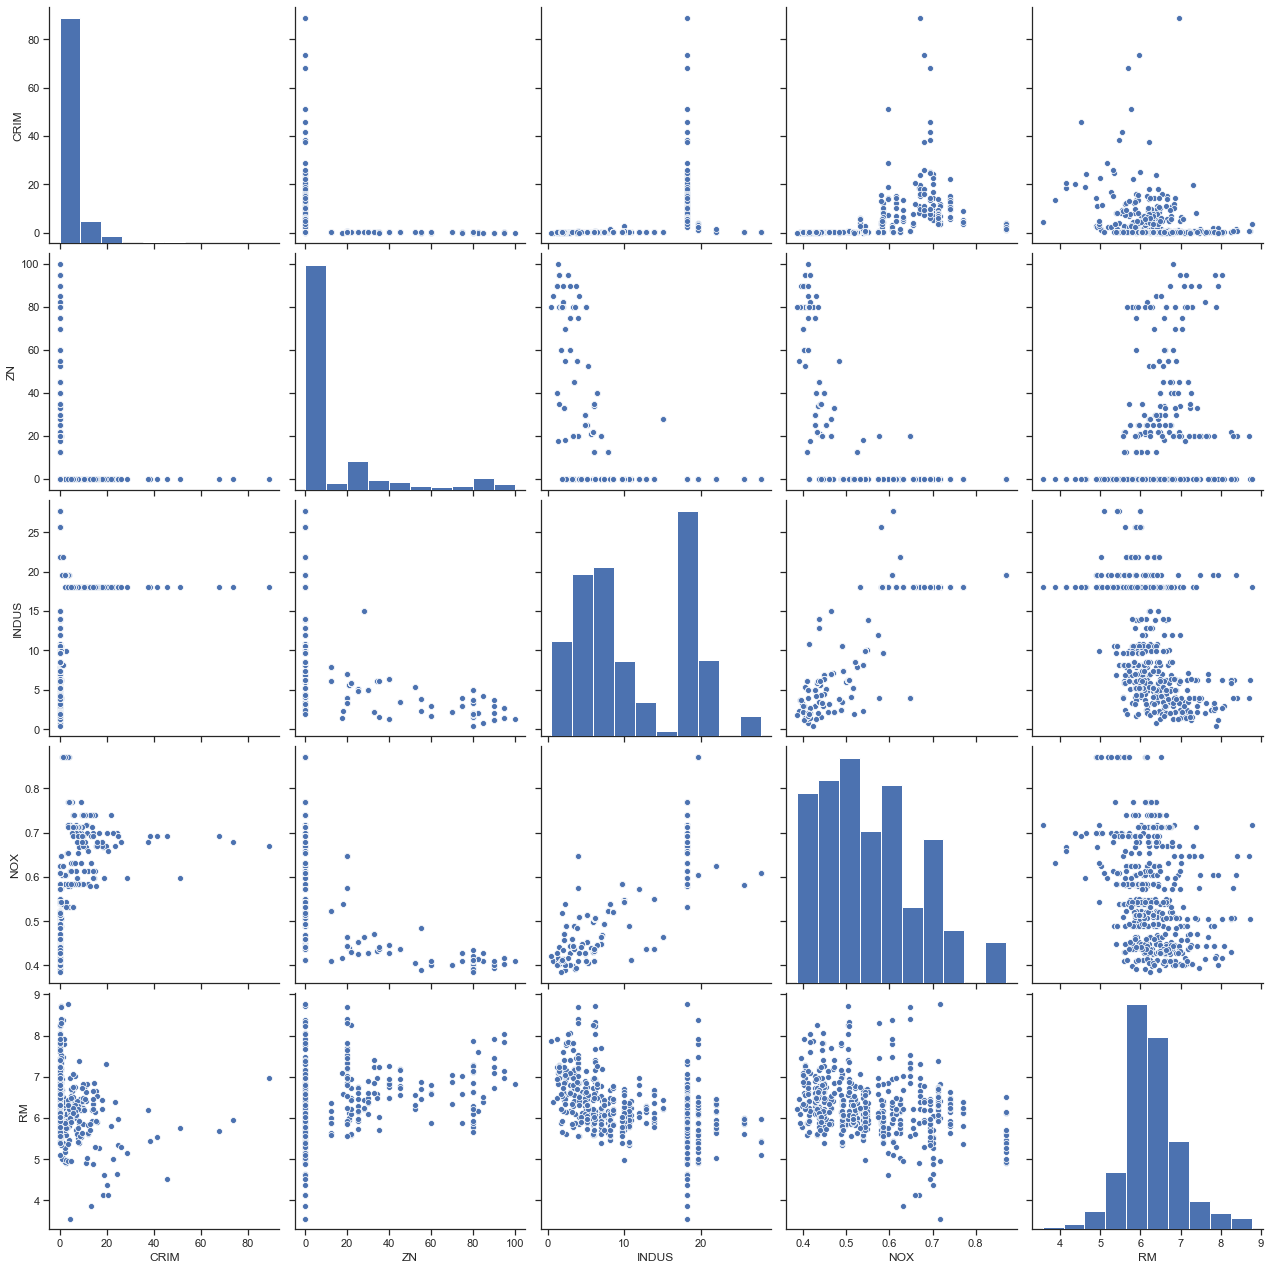

In [7]:
#columns to investigate
col_study = ['CRIM','ZN','INDUS','NOX','RM']

#create pairplot to visualize the differences between CRIM and RM
sns.pairplot(df[col_study], height = 3.5);
plt.show()

> Once we start modeling data we need to be mindful of skewed data

In [8]:
col_study = ['PTRATIO','B','LSTAT','MEDV']

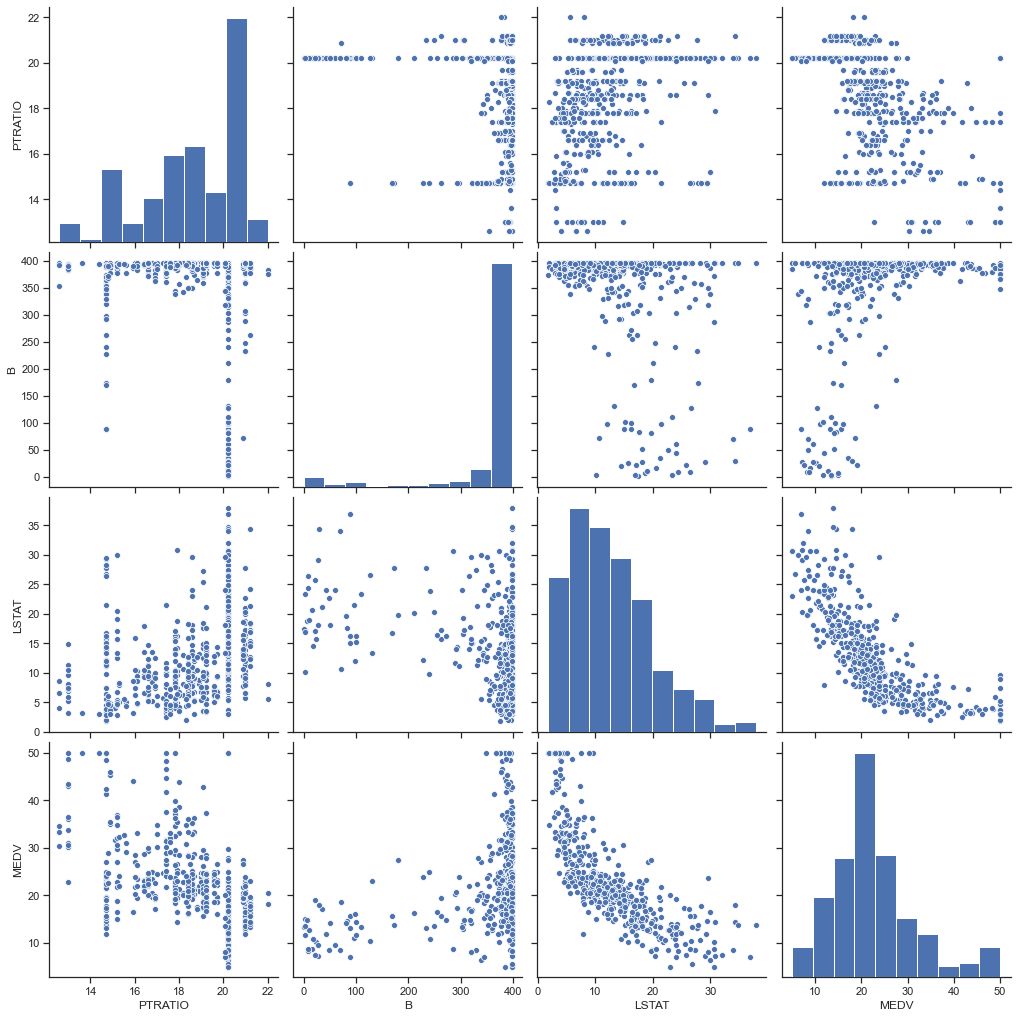

In [9]:
sns.pairplot(df[col_study], height = 3.5)
plt.show()

> The pairplot above show nonlinear relatioships with LSTAT and MEDV. This indicates that the status of the lower population does not have a constant impact on the median value. 
However, there is still some predictiablity here its just not linear. As we look at the relationship between B and MEDV, notice how most data points are packed tightly on the B = ~400. This could indicate that some of this data is dirty. MEDV and PTRATIO has no relationship at all. When performing machine learning we need features that will predict house, try to look at features from a high level 1st, for example if we want to predict house price something like number of rooms, square foot are good predictors. Things like month the house was built or color of the house does not help predict house price. When you see scatterplot with no relationships this are possibly the features you don't need.  

### Correlation Analysis and Feature Selection

In [10]:
# use corr() to run a correlation analysis, which will help me understand how the features interact with each other
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000,-0.200,0.407,-0.056,0.421,-0.219,0.353,-0.380,0.626,0.583,0.290,-0.385,0.456,-0.388
ZN,-0.200,1.000,-0.534,-0.043,-0.517,0.312,-0.570,0.664,-0.312,-0.315,-0.392,0.176,-0.413,0.360
INDUS,0.407,-0.534,1.000,0.063,0.764,-0.392,0.645,-0.708,0.595,0.721,0.383,-0.357,0.604,-0.484
CHAS,-0.056,-0.043,0.063,1.000,0.091,0.091,0.087,-0.099,-0.007,-0.036,-0.122,0.049,-0.054,0.175
NOX,0.421,-0.517,0.764,0.091,1.000,-0.302,0.731,-0.769,0.611,0.668,0.189,-0.380,0.591,-0.427
RM,-0.219,0.312,-0.392,0.091,-0.302,1.000,-0.240,0.205,-0.210,-0.292,-0.356,0.128,-0.614,0.695
AGE,0.353,-0.570,0.645,0.087,0.731,-0.240,1.000,-0.748,0.456,0.506,0.262,-0.274,0.602,-0.377
DIS,-0.380,0.664,-0.708,-0.099,-0.769,0.205,-0.748,1.000,-0.495,-0.534,-0.232,0.292,-0.497,0.250
RAD,0.626,-0.312,0.595,-0.007,0.611,-0.210,0.456,-0.495,1.000,0.910,0.465,-0.444,0.489,-0.382
TAX,0.583,-0.315,0.721,-0.036,0.668,-0.292,0.506,-0.534,0.910,1.000,0.461,-0.442,0.544,-0.469


>Since I'm trying to model simple linear regression with only one variable as the y-value. I need to look for something that is high. So if MEDV is my y, then I will select LSTAT, RM. This is one way to select features, another way to select features is by using a heatmap see below.

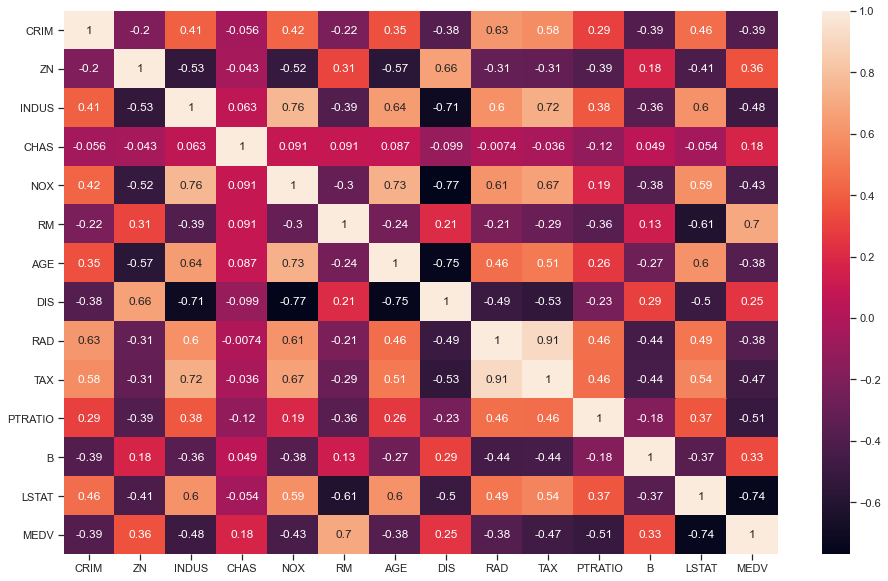

In [11]:
plt.figure(figsize=(16,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

>The heatmap adds some gradient coloring to the correlation matrix, if I wanted to select more features for multiple regression I can take a look at all the values > than .50. Features like PTRATIO, INDUS and TAX may be worth looking at. Also, its important to look at these values in context for example negative numbers explain why the housing prices go down and positive values explain why values go up, again when making this assumption its important only consider values close to that .50 mark, all other values is not significant enough to consider for modeling. 

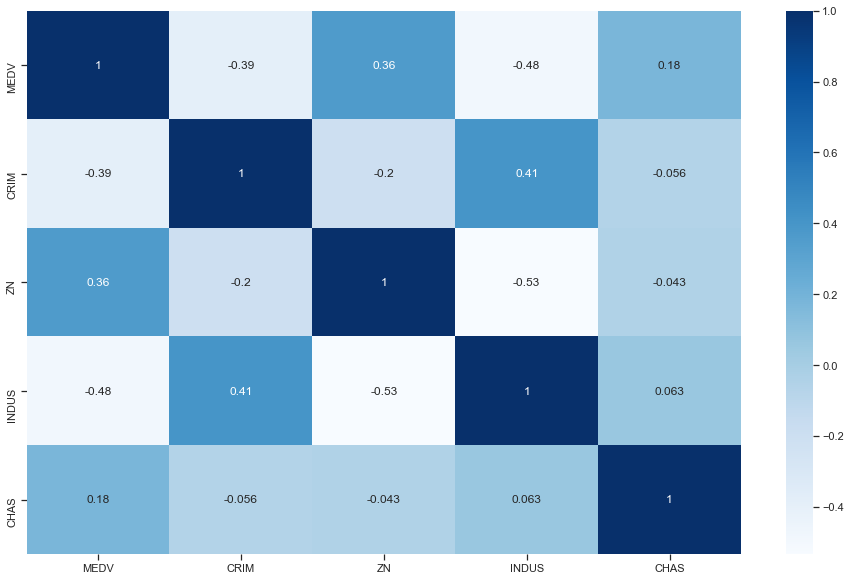

In [12]:
# instructor challenge: produce a correlation matrix with the first 4 columns
plt.figure(figsize=(16,10))
sns.heatmap(df[['MEDV', 'CRIM','ZN','INDUS','CHAS']].corr(), annot = True, cmap = 'Blues')
plt.show()

> Assessing my resluts from the challege: INDUS lowers the price of a house. This does make sense in context since INDUS represents non retail businesses and people usually don't want to live near non-retail businesses because of noise, smells, and waste etc. Here's my feature list based on the correlation matrix above:
- LSTAT (-.74)
- RM (-.7)
- PTRATIO (-.51)
- INDUS (-.48)
- TAX (-.47)

> For now I will only use one feature to develop my linear regression model. 

### Linear Regression with SciKit-Learn

In [13]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.006,18.000,2.310,0,0.538,6.575,65.200,4.090,1,296.000,15.300,396.900,4.980,24.000
1,0.027,0.000,7.070,0,0.469,6.421,78.900,4.967,2,242.000,17.800,396.900,9.140,21.600
2,0.027,0.000,7.070,0,0.469,7.185,61.100,4.967,2,242.000,17.800,392.830,4.030,34.700
3,0.032,0.000,2.180,0,0.458,6.998,45.800,6.062,3,222.000,18.700,394.630,2.940,33.400
4,0.069,0.000,2.180,0,0.458,7.147,54.200,6.062,3,222.000,18.700,396.900,5.330,36.200


In [14]:
# Below I am reshaping the RM column so that sci-kit learn can make use of it. This will be my predictor variable
X = df['RM'].values.reshape(-1,1)

In [15]:
# The line of ceode below selects the target variable from the dataset
y = df['MEDV'].values

In [16]:
# Instantiate the machine learning model, if I wanted to I can make use of many instantiations. For example I can model1 make use of LSTAT, model2 make use of PTRATIO, model3 make use of INDUS, and model4 make use of all features.
model = LinearRegression()

In [17]:
# fitting the variables to the linear regression model, this provides the machine learning model with the underlying data
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
# In linear regression, coefficients are the values that mulitply the predictor value. The coefficient value represents the mean change is response given a one unit change is the predictor.
# Below I can see the mean response increases by 9 for every one unit of change in the predictor. 
# In context this means: Each additional room an house increases its median value by 9 units
model.coef_

array([9.10210898])

In [19]:
# In linear regression when x = 0, the corresponding y-value is the y-intercept
# In context this means: When a house has 0 rooms its median value is -34
model.intercept_

-34.67062077643857

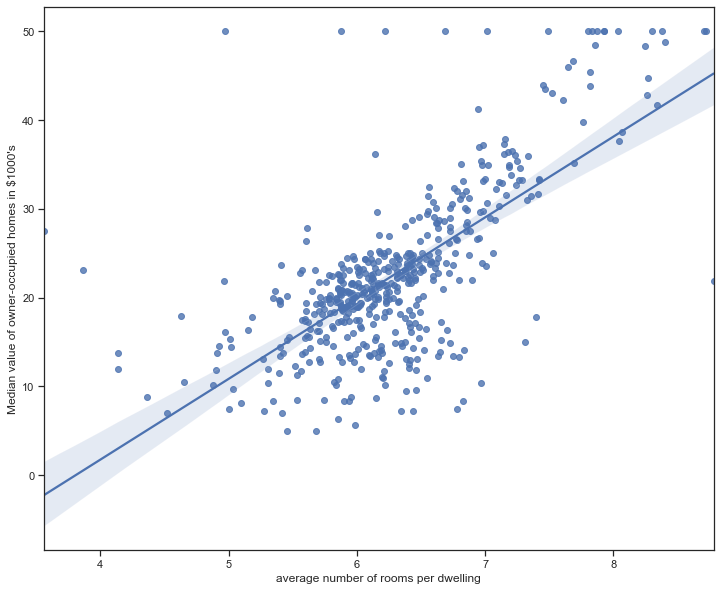

In [20]:
# Creates a regression plot to show the relationship between X and y
plt.figure(figsize=(12,10));
sns.regplot(X,y);
plt.xlabel('average number of rooms per dwelling')
plt.ylabel("Median value of owner-occupied homes in $1000's")
plt.show();

> The plot shows that as the number of rooms increase so does the median value. For the most part this is accurate, however there is some noise in the data:
- There looks to be 'ceiling' in the data which can indicate that some houses have higher medians, but $50,000 is the max input
- I can see some outliers ex. 9 rooms with a high median 

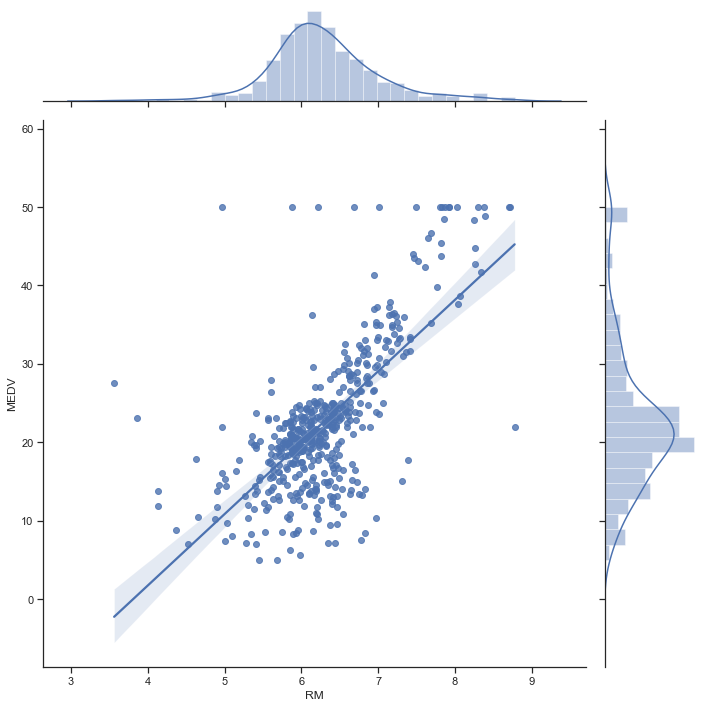

In [21]:
# I can also use an seaborn jointplot to assess the relationship between X,y
sns.jointplot(x='RM', y='MEDV', data= df, kind='reg', height=10);
plt.show();

> I like this graph better because it shows the distribution of the two variables as well as the relationship. Here I can see:
- RM has a normal distribution and a mean of ~6
- MEDV has a normal distribution and a mean of ~20,000k
- I can see a little more detail, since now its clear that there's a ceiling in the data for the MEDV (even though the graph show a max of 60,000k all values stop at 50,000k
- There are some outliers, and noise in the data but in general RM seems to be a good predictor of MEDV(target variable)

In [22]:
# make a prediction using the model we just developed
# since I only have one predictor value, I can just insert the number of rooms into the numpy array 
model.predict(np.array([7]).reshape(1,-1))

array([29.04414209])

### Five Steps in the Machine Learning Process

1. Choose a class of model by importing the appropiate estimator class from Scikit-Learn.
2. Choose model hyperparameters by instantiating this class with desired values.
3. Arrange data into a features matrix and target vector.
4. Fit the model to your data by calling the fit() method of the model instance.
5. Apply the model to new data:
    - For supervised learning, often we predict labels for unknown data using the predict() method.
    - For unsupervised learning, we often transform or infer properties of the data using the transform() or predict() method.

In [23]:
# Step 1 
# from sklearn.linear_model import LinearRegression

# Step2
ml_2 = LinearRegression()

#Step 3
X2 = df['LSTAT'].values.reshape(-1,1)
y2 = df['MEDV'].values

#Step 4
ml_2.fit(X2,y2)

#Step 5
ml_2.predict(np.array([15]).reshape(1,-1))

array([20.30310057])

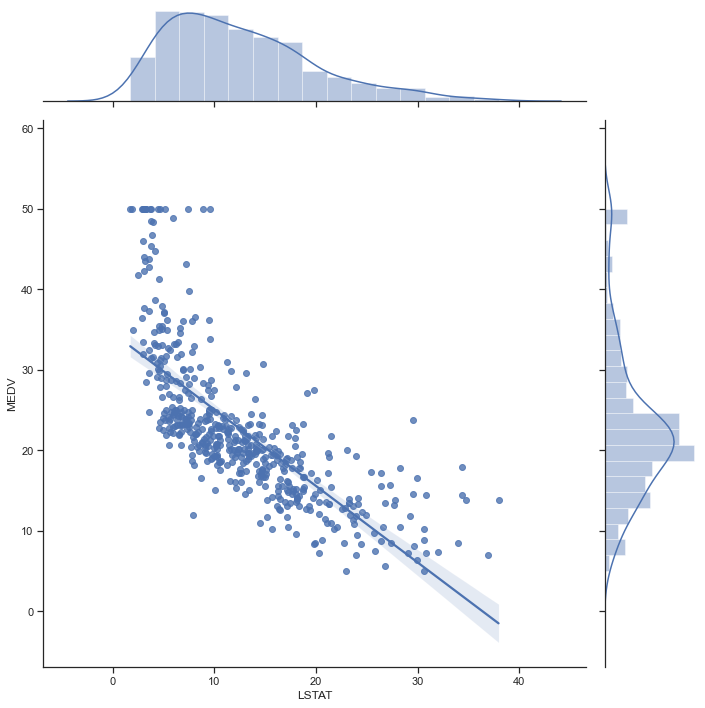

In [24]:
# I can also use an seaborn jointplot to assess the relationship between X,y
sns.jointplot(x='LSTAT', y='MEDV', data= df, kind='reg', height=10);
plt.show();

### Robust Regression
- Outlier Demo: [http://digitalfirst.bfwpub.com/stats_applet/stats_applet_5_correg.html](http://digitalfirst.bfwpub.com/stats_applet/stats_applet_5_correg.html)

Robust regression is useful since in the real world most datasets do not follow the four assumptions of linear regression, the four assumptions are:
1. Linearity: The relationship between X and the mean of Y is linear.
2. Homoscedasticity: The variance of residual is the same for any value of X.
3. Independence: Observations are independent of each other.
4. Normality: For any fixed value of X, Y is normally distributed. (outliers can impact the coefficient-See screenshot below)

<img src="img1.png">
<img src="img2.jpg">

#### RANdom SAmple Consensus (RANSAC) Algorithm

link = [http://scikit-learn.org/stable/modules/linear_model.html#ransac-regression](http://scikit-learn.org/stable/modules/linear_model.html#ransac-regression)

Each iteration performs the following steps:

1. Select `min_samples` random samples from the original data and check whether the set of data is valid (see `is_data_valid`).

2. Fit a model to the random subset (`base_estimator.fit`) and check whether the estimated model is valid (see `is_model_valid`).

3. Classify all data as inliers or outliers by calculating the residuals to the estimated model (`base_estimator.predict(X) - y`) - all data samples with absolute residuals smaller than the `residual_threshold` are considered as inliers.

4. Save fitted model as best model if number of inlier samples is maximal. In case the current estimated model has the same number of inliers, it is only considered as the best model if it has better score.

In [47]:
#declare x and y values
X3 = df['RM'].values.reshape(-1,1)
y3 = df['MEDV'].values

#instantiate model
ransac = RANSACRegressor()

#fit the model
ransac.fit(X3,y3)

#determine inlier and outlier
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

In [56]:
#declares predictor variables
line_X = np.arange(3,10,1)

# predict various points on the x-axis
line_y_ransac = ransac.predict(line_X.reshape(-1,1))

#compare linear regression and RANSAC predictions
print('Linear',model.predict(np.array([7]).reshape(1,-1)))
print('RANSAC',ransac.predict(np.array([7]).reshape(1,-1)))

Linear [29.04414209]
RANSAC [31.79162833]


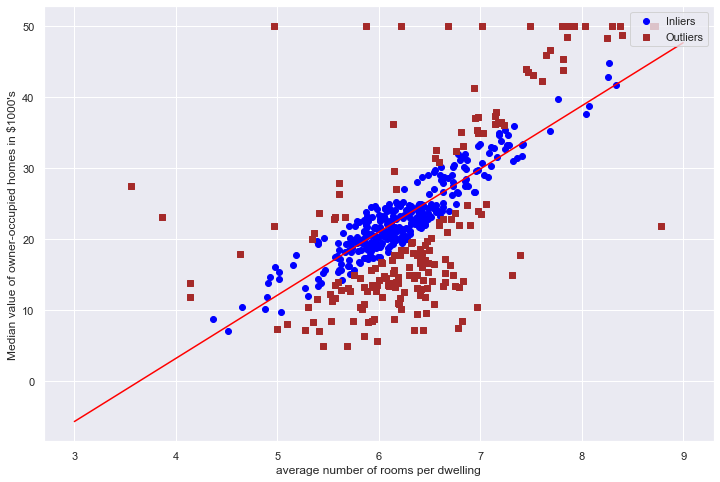

In [40]:
sns.set(style='darkgrid', context='notebook')
plt.figure(figsize=(12,8));
plt.scatter(X3[inlier_mask], y3[inlier_mask], 
            c='blue', marker='o', label='Inliers')
plt.scatter(X3[outlier_mask], y3[outlier_mask],
            c='brown', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('average number of rooms per dwelling')
plt.ylabel("Median value of owner-occupied homes in $1000's")
plt.legend(loc='upper right')
plt.show()

>The scatter plot shows how the RANSAC model drops outliers (when using RANSAC be sure to use the inlier attirbute, since you have to 'mask' the inliers and outliers). Also, its important to interpret the scatter plots correctly, sometimes the line of best fit is not linear in that case RANSAC will just produce a junk model. See Below

In [43]:
#declare x and y values
X4 = df['LSTAT'].values.reshape(-1,1)
y4 = df['MEDV'].values

#instantiate model
ransac = RANSACRegressor()

#fit the model
ransac.fit(X4,y4)

#determine inlier and outlier
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

#declares predictor variables
line_X = np.arange(0,40,1)

#make predictions
line_y_ransac = ransac.predict(line_X.reshape(-1,1))

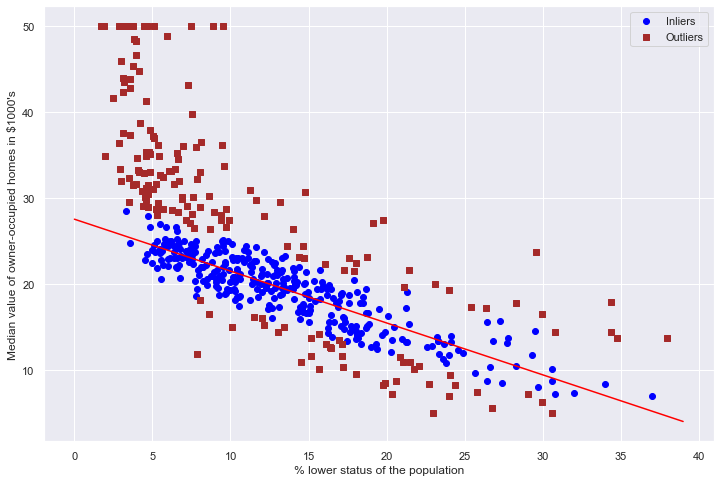

In [44]:
sns.set(style='darkgrid', context='notebook')
plt.figure(figsize=(12,8));
plt.scatter(X4[inlier_mask], y4[inlier_mask], 
            c='blue', marker='o', label='Inliers')
plt.scatter(X4[outlier_mask], y4[outlier_mask],
            c='brown', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('% lower status of the population')
plt.ylabel("Median value of owner-occupied homes in $1000's")
plt.legend(loc='upper right')
plt.show()

> The line of best fit for the scatter plot above is not linear, the plot shows a curve. Using linear regression will create a garbage in garbage out model. 

### Evaluate Regression Model Performance

In [57]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.006,18.000,2.310,0,0.538,6.575,65.200,4.090,1,296.000,15.300,396.900,4.980,24.000
1,0.027,0.000,7.070,0,0.469,6.421,78.900,4.967,2,242.000,17.800,396.900,9.140,21.600
2,0.027,0.000,7.070,0,0.469,7.185,61.100,4.967,2,242.000,17.800,392.830,4.030,34.700
3,0.032,0.000,2.180,0,0.458,6.998,45.800,6.062,3,222.000,18.700,394.630,2.940,33.400
4,0.069,0.000,2.180,0,0.458,7.147,54.200,6.062,3,222.000,18.700,396.900,5.330,36.200


In [65]:
# this line of code takes the dataframe and store all the columns except the last as independent variables (x); values stores the data as an array
X = df.iloc[:, :-1].values

# this line of code takes the dataframe and the MEDV as the dependent variable (y); values stores the data as an array
y = df['MEDV'].values

# this line of code splits the dataframe into a train and test set which can used to evaluate model performance
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=0)

In [66]:
# instatiate the model
lr = LinearRegression()

#fit the model
lr.fit(X_train, y_train)

#make predictions on train set
y_train_pred = lr.predict(X_train)

#make predictions on test set
y_test_pred = lr.predict(X_test)

#### Method 1: Residual Analysis

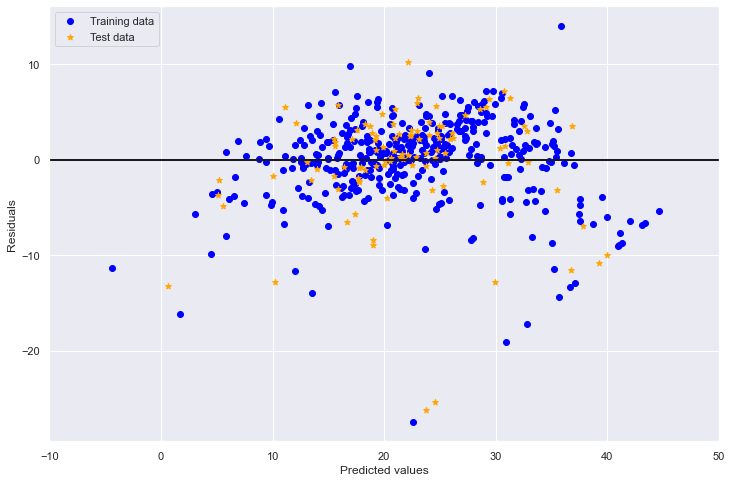

In [74]:
# this section of code will plot the train and test predictions on a scatter plot
plt.figure(figsize=(12,8))
plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='orange', marker='*', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='k')
plt.xlim([-10, 50])
plt.show()

> From the plot above we can see that the training predictions have a few outliers, but generally I cannot see a pattern. Looking at the test result I can see the same thing, there's a few outliers but no recognizable pattern. The important to recognize here is that the train and test predictions have similiar plots, this is a good thing and indicates that the test data is representative of the train data and vice versa. Training data needs to be representative of the real world data. Since the error values are fairly large this indicates that the model is not the best at predicting.

#### Method 2: Mean Squared Error (MSE)

$$MSE=\frac{1}{n}\sum^n_{i=1}(y_i-\hat{y}_i)^2$$

* The average value of the Sums of Squared Error cost function
* Useful for comparing different regression models 
* For tuning parameters via a grid search and cross-validation
* The lower the number the better

In [77]:
from sklearn.metrics import mean_squared_error
print("MSE for training data:",mean_squared_error(y_train, y_train_pred))
print("MSE for testing data:",mean_squared_error(y_test, y_test_pred))

MSE for training data: 19.326470203585725
MSE for testing data: 33.448979997676474


> The outputs above shows that the model performed better on the train data, this is a common instance.

#### Method 3: Coefficient of Determination, $R^2$

$$R^2 = 1 - \frac{SSE}{SST}$$

SSE: Sum of squared errors

SST: Total sum of squares
* The lower the number the better

In [79]:
from sklearn.metrics import r2_score
print("R-Square for the training data:",r2_score(y_train, y_train_pred))
print("R-square for the testing data:",r2_score(y_test, y_test_pred))

R-Square for the training data: 0.7730135569264234
R-square for the testing data: 0.5892223849182514


> The outputs above shows that the model performed better on the train data, this is a common instance.

#### What does a Near Perfect Model Looks like?

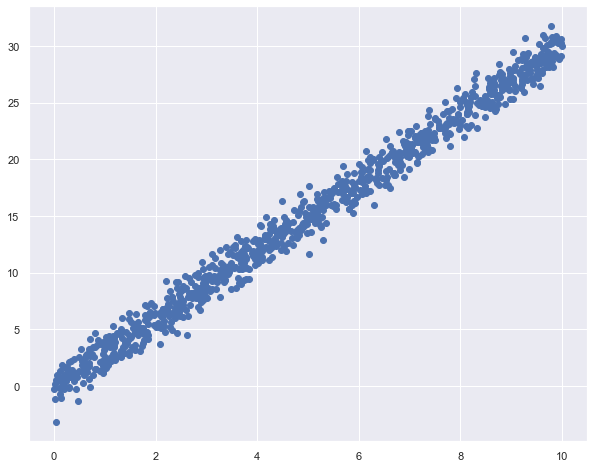

In [89]:
generate_random = np.random.RandomState(0)
x = 10 * generate_random.rand(1000)
y = 3 * x + np.random.randn(1000)
plt.figure(figsize = (10, 8))
plt.scatter(x, y);
plt.show()

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X_train.reshape(-1, 1), y_train)


y_train_pred = model.predict(X_train.reshape(-1, 1))
y_test_pred = model.predict(X_test.reshape(-1, 1))

#### Method 1: Residual Analysis

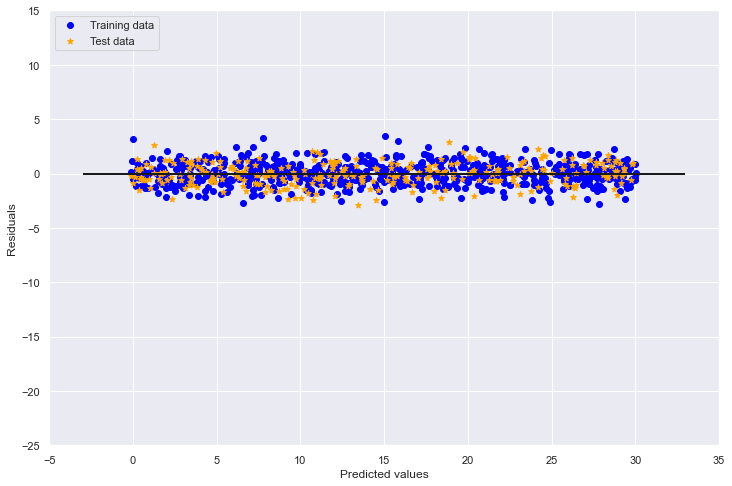

In [91]:
plt.figure(figsize=(12,8))
plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='orange', marker='*', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-3, xmax=33, lw=2, color='k')
plt.xlim([-5, 35])
plt.ylim([-25, 15])
plt.show()

#### Method 2: Mean Squared Error (MSE)

In [92]:
print("train:",mean_squared_error(y_train, y_train_pred))
print("test:",mean_squared_error(y_test, y_test_pred))

train: 0.9954341990667701
test: 0.9937057050090546


#### Method 3: Coefficient of Determination, $R^2$

In [93]:
print("train:",r2_score(y_train, y_train_pred))
print("test:",r2_score(y_test, y_test_pred))

train: 0.9871306397355611
test: 0.9870771375485736
